# Телеком

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

<b> Описание услуг </b>

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

<b>План решения задачи </b>

1. Подготовка данных: импорт необходимых для работы библиотек, загрузка датасетов, вывод информации о них, перевод данных в необходимые форматы (при необходимости), оценка количества дубликатов и пропусков, работа с ними
2. Анализ данных: оценка признаков и целевого признака, построение графиков, изучение мультиколлинеарности и баланса классов
3. Обучение моделей: разделение датасета на выборки, преобразования категориальных признаков в численные, стандартизация численных признаков, построение нескольких моделей и оценка метрик на каждой из моделей, а также оценка времени обучения и предсказания 
4. Тестирование модели: выбор наилучшей модели из обученных ранее, проверка выбранной модели на тестовой выборке, оценка полученных метрик на тестовой выборке
5. Выводы о проделанной работе

## Подготовка данных

Начнем работу с загрузки и импорта необходимых для работы библиотек:

In [1]:
!pip install phik
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 679 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 30.8 MB 48 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from termcolor import colored
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Также сразу зададим значение константы RANDOM_STATE

In [3]:
RANDOM_STATE=240423

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020.

Откроем датасеты, выведем первые несколько строк, а также выведем информацию о них

In [4]:
print(colored('   Информация о договоре', "green"))
data0 = pd.read_csv('/datasets/contract_new.csv')
display(data0.sample(5))
data0.info()
print()
print(colored('   Персональные данные клиента', "red"))
data1 = pd.read_csv('/datasets/personal_new.csv')
display(data1.sample(5))
data1.info()
print()
print(colored('   Информация об интернет-услугах', "blue"))
data2 = pd.read_csv('/datasets/internet_new.csv')
display(data2.sample(5))
data2.info()
print()
print(colored('   Информация об услугах телефонии', "magenta"))
data3 = pd.read_csv('/datasets/phone_new.csv')
display(data3.sample(5))
data3.info()

   Информация о договоре


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1371,6567-HOOPW,2019-11-01,No,Month-to-month,Yes,Electronic check,79.20,237.6
4686,8024-XNAFQ,2014-02-01,2016-03-01,Two year,Yes,Bank transfer (automatic),107.40,2711.85
1792,8401-EMUWF,2016-08-01,No,Month-to-month,Yes,Bank transfer (automatic),69.40,3177.13
75,2673-CXQEU,2015-06-01,No,One year,No,Electronic check,110.50,6435.52
6769,9916-AYHTC,2016-02-01,No,Two year,No,Credit card (automatic),19.85,952.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

   Персональные данные клиента


,customerID,gender,SeniorCitizen,Partner,Dependents
2428,2519-FAKOD,Male,0,No,Yes
1976,9497-QCMMS,Male,1,No,No
3154,0581-BXBUB,Female,1,No,No
3459,6609-MXJHJ,Female,0,Yes,Yes
1654,2967-MXRAV,Male,0,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

   Информация об интернет-услугах


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3059,0991-BRRFB,DSL,Yes,No,No,No,No,No
2485,2834-SPCJV,Fiber optic,Yes,No,No,No,Yes,No
4752,4024-CSNBY,Fiber optic,Yes,Yes,Yes,Yes,No,No
1395,3669-WHAFY,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
1914,3893-JRNFS,DSL,No,No,Yes,No,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

   Информация об услугах телефонии


,customerID,MultipleLines
6188,6127-IYJOZ,No
921,3863-IUBJR,No
1703,0923-PNFUB,No
5632,2446-BEGGB,Yes
217,4522-AKYLR,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Как мы видим пропуски в датасетах отсутствуют, однако количество строк в датасетах отличается. Это можно объяснить тем, что не всегда клиенты пользуются и интернетом и телефонией одновременно

Объединим наши датасеты в один общий для дальнейшей работы:

In [5]:
data=data0.merge(
    data1, on='customerID', how='left').merge(
    data2, on='customerID', how='left').merge(
    data3, on='customerID', how='left')

In [6]:
display(data.sample(10))
data.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
829,5337-IIWKZ,2017-04-01,No,Month-to-month,Yes,Electronic check,44.85,1585.9,Male,0,Yes,Yes,DSL,No,No,Yes,Yes,Yes,No,NaN
7004,6075-SLNIL,2016-12-01,2019-02-01,Month-to-month,Yes,Credit card (automatic),95.10,2472.6,Male,0,No,No,Fiber optic,No,Yes,Yes,No,No,Yes,Yes
6759,1591-MQJTP,2015-11-01,No,One year,Yes,Bank transfer (automatic),93.65,4776.15,Male,1,Yes,No,Fiber optic,Yes,No,Yes,No,No,Yes,Yes
4579,5650-YLIBA,2017-07-01,No,Month-to-month,Yes,Electronic check,81.15,2515.65,Male,0,No,No,Fiber optic,No,Yes,No,No,No,No,Yes
5539,4632-PAOYU,2018-04-01,No,One year,No,Mailed check,19.95,456.46,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
31,4929-XIHVW,2019-12-01,No,Month-to-month,Yes,Credit card (automatic),95.50,194.82,Male,1,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,No
5852,3398-ZOUAA,2018-01-01,No,Month-to-month,Yes,Electronic check,69.10,1865.7,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,No
2085,8290-YWKHZ,2017-03-01,No,Month-to-month,Yes,Electronic check,93.20,3490.34,Female,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Yes
3630,9986-BONCE,2019-08-01,No,Month-to-month,No,Bank transfer (automatic),20.95,137.01,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3264,6818-DJXAA,2019-04-01,No,Month-to-month,Yes,Electronic check,91.10,911.0,Female,0,No,Yes,Fiber optic,No,No,Yes,Yes,Yes,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Посмотрим на количество дубликатов:

In [7]:
print(data.duplicated().sum())

0


Как видим дубликаты отсутствуют

Целью работы является создание модели способной спрогнозировать отток клиентов. Соответственно целевым признаком будет столбец с информацией о том является ли человек клиентом оператор связи или уже нет. Информацию о дате окончания пользования услугами мы можем найти в столбце 'EndDate': если дата имеется, то человек больше не является клиентом оператора. Для удобства создадим отдельный столбец для целевого признака с информацией о статусе в бинарном виде

In [8]:
data.loc[data['EndDate'] != 'No', 'status'] = 0
data.loc[data['EndDate'] == 'No', 'status'] = 1

Посмотрим как теперь выглядит датасет:

In [9]:
display(data.sample(10))
data.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,status
5443,7109-MFBYV,2017-12-01,No,Month-to-month,No,Electronic check,45.45,1181.7,Male,0,...,No,DSL,No,No,No,No,No,No,No,1.0
3184,5197-LQXXH,2014-03-01,No,Two year,Yes,Credit card (automatic),83.30,5914.3,Female,0,...,No,DSL,No,Yes,Yes,Yes,Yes,Yes,Yes,1.0
6634,1465-VINDH,2019-02-01,No,Month-to-month,Yes,Credit card (automatic),102.10,1225.2,Female,0,...,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,1.0
3094,1898-JSNDC,2016-11-01,No,One year,Yes,Credit card (automatic),58.60,2285.4,Female,0,...,No,DSL,No,Yes,No,No,Yes,No,No,1.0
1707,4854-CIDCF,2019-11-01,No,Month-to-month,No,Electronic check,73.85,237.06,Female,1,...,No,Fiber optic,No,No,Yes,No,No,No,No,1.0
3691,2150-WLKUW,2016-10-01,No,One year,No,Bank transfer (automatic),63.90,2556.0,Female,0,...,No,DSL,No,Yes,No,No,Yes,No,Yes,1.0
4201,1166-PQLGG,2014-02-01,No,Two year,No,Bank transfer (automatic),19.55,1492.06,Female,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0
6453,8634-MPHTR,2016-02-01,2019-08-01,Month-to-month,Yes,Electronic check,100.05,4412.2,Male,1,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0.0
4791,7808-DVWEP,2019-11-01,No,Month-to-month,No,Bank transfer (automatic),20.00,65.4,Male,0,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0
4648,9717-QEBGU,2019-12-01,No,Month-to-month,Yes,Electronic check,70.30,147.63,Male,0,...,No,Fiber optic,No,No,No,No,No,No,No,1.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


## Анализ данных

Как видим все в порядке. Далее можем заняться каждым столбцом по отдельности

<b>Вывод: </b> Мы оценили исходный датасет, узнали его размер и количество пропусков, определили целевой признак

У нас имеются столбцы 'BeginDate' и 'EndDate' с информацией о дате начала пользования услугами и окончании. Создадим признак с информацией о времени пользования услугами. Но перед этим займемся редактированием столбца 'EndDate'. Поскольку многие пользователи являются пользователями оператора связи, у них отсутствует дата окончания пользования услугами. Для таких клиентов заполним значение столбца 'EndDate' датой на которую актуальны договора по условию (1 февраля 2020)

In [10]:
data.loc[data['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

Заодно проверим столбцы 'BeginDate' и 'EndDate' на наличие аномалий - даты в них не должны быть позже 1 февраля 2020. Предварительно переведем эти столбцы в формат даты

In [11]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'])
data['EndDate'] = pd.to_datetime(data['EndDate'])                      

In [12]:
print(data['BeginDate'].max())
print(data['EndDate'].max())

2020-02-01 00:00:00
2020-02-01 00:00:00


Как мы видим аномалии отстутствуют - можно создавать новый признак с информацией о времени пользования услугами. Заодно после этого переведем значения в новом столбце в более подходящий формат

In [13]:
data['time'] = data['EndDate'] - data['BeginDate']
data['time'] = data['time'].dt.days

Посмотрим на значения в столбце 'Type' (тип оплаты) и построим по значениям этого столбца график

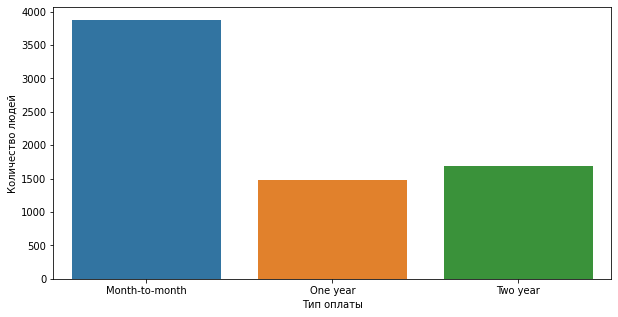

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64


In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=data, x='Type')
plt.ylabel('Количество людей')
plt.xlabel('Тип оплаты')
plt.show()
print(data['Type'].value_counts())

Как мы видим чаще всего люди предпочитают ежемесячный тип оплаты, далее идет двухгодичный тип оплаты и еще реже люди выбирают годовой тип оплаты

Далее посмотрим на распределения в столбцах 'PaperlessBilling' (электронный платежный документ) и 'PaymentMethod' (способ оплаты) и построим соответствующие графики

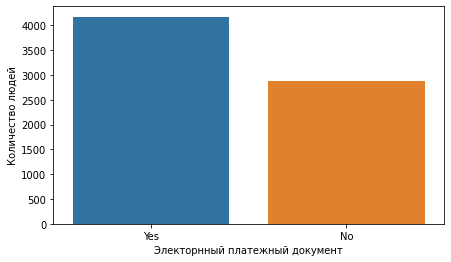

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64


In [15]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=data, x='PaperlessBilling')
plt.ylabel('Количество людей')
plt.xlabel('Электорнный платежный документ')
plt.show()
print(data['PaperlessBilling'].value_counts())

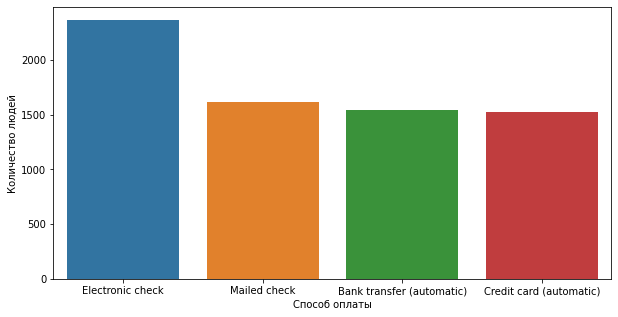

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=data, x='PaymentMethod')
plt.ylabel('Количество людей')
plt.xlabel('Способ оплаты')
plt.show()
print(data['PaymentMethod'].value_counts())

Как мы видим чаще всего клиенты предпочитают использовать электронный чек в качестве способа оплаты и иметь электорнный платежный документ

Посмотрим на значения в столбце 'MonthlyCharges' (ежемесячные траты на услуги) и построим по значениям этого столбца график

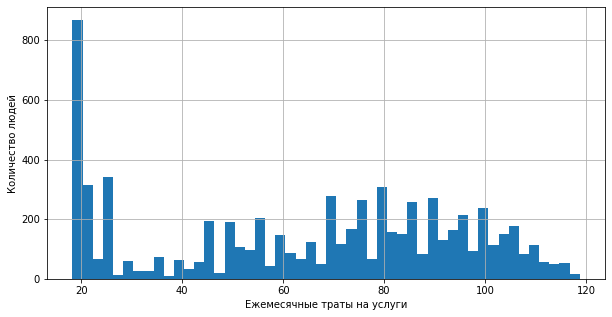

20.05     61
19.85     45
19.90     44
19.95     44
19.65     43
          ..
87.65      1
35.30      1
114.85     1
56.50      1
97.25      1
Name: MonthlyCharges, Length: 1585, dtype: int64


In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
data['MonthlyCharges'].hist(bins=50)
plt.ylabel('Количество людей')
plt.xlabel('Ежемесячные траты на услуги')
plt.show()
print(data['MonthlyCharges'].value_counts())

Как мы видим чаще всего люди тратят около 20 у.е. на услуги в месяц. Однако немало и тех, кто платит от 45 до 100 у.е. в месяц

Далее посмотрим на значения в столбце 'TotalCharges' (суммарные траты на услуги) и построим по значениям этого столбца график

In [18]:
print(data['TotalCharges'].value_counts())

           11
20.45       6
101.0       5
19.65       4
40.1        4
           ..
348.6       1
1412.32     1
1886.0      1
1272.0      1
216.65      1
Name: TotalCharges, Length: 6658, dtype: int64


Как мы видим у нас имеются пустые значения в данном столбце - возможно была ошибка в выгрузке данных или это клиенты с нулевыми суммарными тратами на услуги на момент выгрузки данных (например, новые клиенты). Посмотрим на этих клиентов повнимательнее

In [19]:
display(data.loc[data['TotalCharges'] == ' '])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,status,time
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,NaN,1.0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,0,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,1.0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,1.0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,0,...,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,1.0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,1.0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,Female,0,...,DSL,No,Yes,Yes,Yes,Yes,No,Yes,1.0,0


Как мы видим у всех этих клиентов начало пользования услугами совпадает с днем выгрузки данных, поэтому нулевые суммарные траты на услуги у них выглядят логично. Мы можем заполнить данные пропуски нулями или, еще лучше, избавиться от них - поскольку таких значений немного и чтобы они не портили картину будущих предсказаний

In [20]:
data = data.loc[data['TotalCharges'] != ' ']

Теперь поменяем тип данных на более подходящий и построим по значениям этого столбца график и диаграмму типа 'ящик с усами'. Заодно оценим минимальное и максимальное значение суммарных затрат на услуги (чтобы избежать аномальных значений)

In [21]:
data['TotalCharges'] = data['TotalCharges'].astype('float64')

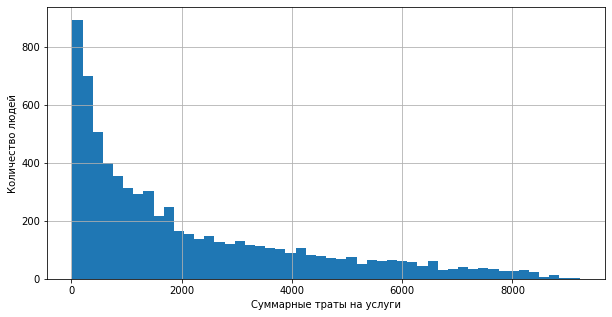

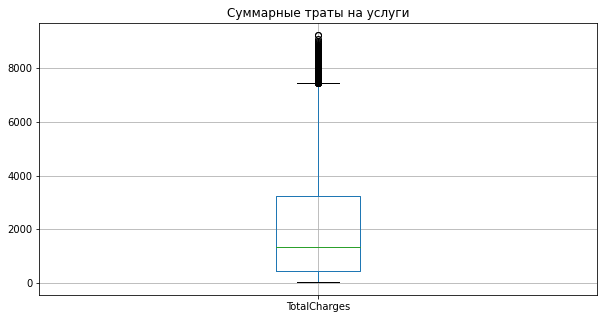

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: TotalCharges, dtype: float64

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
data['TotalCharges'].hist(bins = 50)
plt.ylabel('Количество людей')
plt.xlabel('Суммарные траты на услуги')
plt.show()
fig, ax = plt.subplots(figsize=(10, 5))
data.boxplot(column='TotalCharges')
plt.title('Суммарные траты на услуги')
plt.show()
data['TotalCharges'].describe()

Как мы видим, клиенты чаще всего имеют суммарные затраты на услуги от 440 до 3200 у.е., минимальное значение трат составляет 19 у.е. (стоимость оказания услуг за один месяц), а максимальное значение трат - 9221 у.е., что выглядит правдоподобно при больших ежемесячных тратах и долгом пользовании услугами.

Посмотрим на распределения в столбцах в столбцах, связанных с персональными данными клиентов: 'gender',	'SeniorCitizen', 'Partner',	'Dependents' и построим соответствующие графики

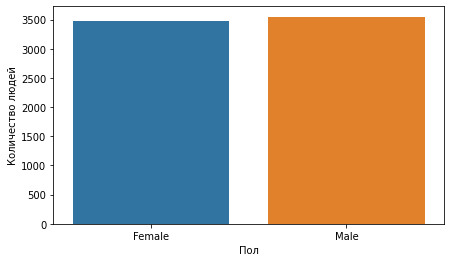

Male      3549
Female    3483
Name: gender, dtype: int64


In [23]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=data, x='gender')
plt.ylabel('Количество людей')
plt.xlabel('Пол')
plt.show()
print(data['gender'].value_counts())

Как мы видим клиенты имеют почти равное распределение по полу, что вполне логично

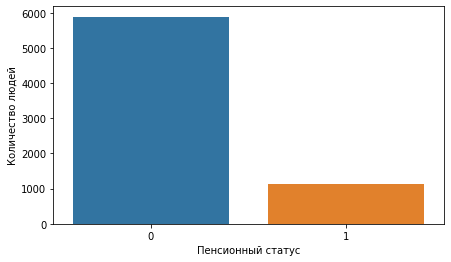

0    5890
1    1142
Name: SeniorCitizen, dtype: int64


In [24]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=data, x='SeniorCitizen')
plt.ylabel('Количество людей')
plt.xlabel('Пенсионный статус')
plt.show()
print(data['SeniorCitizen'].value_counts())

Примерно 1/6 часть клиентов являются пенсионерами

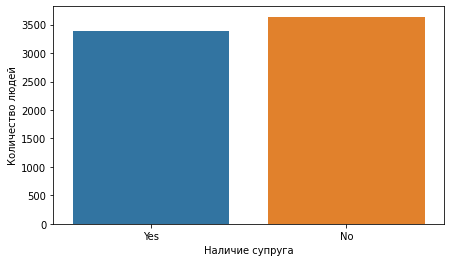

No     3639
Yes    3393
Name: Partner, dtype: int64


In [25]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=data, x='Partner')
plt.ylabel('Количество людей')
plt.xlabel('Наличие супруга')
plt.show()
print(data['Partner'].value_counts())

Примерно равные части клиентов имеют и не имеют супругов

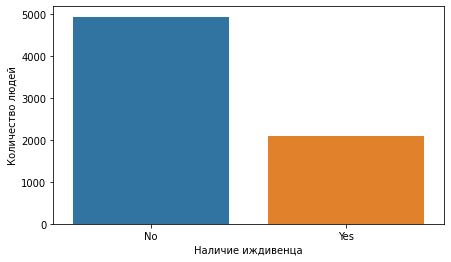

No     4933
Yes    2099
Name: Dependents, dtype: int64


In [26]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=data, x='Dependents')
plt.ylabel('Количество людей')
plt.xlabel('Наличие иждивенца')
plt.show()
print(data['Dependents'].value_counts())

Клиентов без иждивенцев в два с лишним раза больше чем с иждивенцами

Теперь посмотрим на столбцы, содержащие информацию об интернет-услугах: 'InternetService',	'OnlineSecurity',	'OnlineBackup', 'DeviceProtection',	'TechSupport',	'StreamingTV',	'StreamingMovies'. Для данных столбцов нам необходимо учесть, что в них после объединения исходных файлов имеются пропуски поскольку не все клиенты пользуются интернетом

Начнем со столбца 'InternetService' - в нем содержится информация о технологии интернета: Fiber optic (оптоволокно) или DSL (телефонная сеть). Также нам необходимо посмотреть на пропуски в этом столбце   

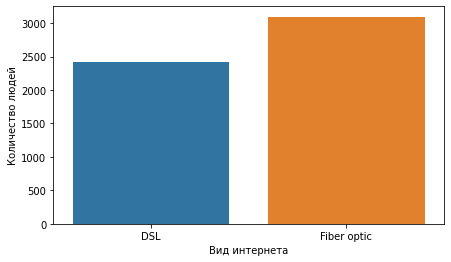

Fiber optic    3096
DSL            2416
Name: InternetService, dtype: int64
Количество пропусков:  1520


In [27]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=data, x='InternetService')
plt.ylabel('Количество людей')
plt.xlabel('Вид интернета')
plt.show()
print(data['InternetService'].value_counts())
print('Количество пропусков: ', data['InternetService'].isna().sum())

Мы видим, что количество клиентов использующих Fiber optic (оптоволокно) чуть больше чем пользователей DSL технологии. Пропуски заполним значением 'No'

In [28]:
data['InternetService'] = data['InternetService'].fillna('No')

Далее посмотрим на столбцы с дополнительными интернет-услугами: 'OnlineSecurity' (онлайн безопасность), 'OnlineBackup' (резервное копирование), 'DeviceProtection' (защита устройства), 'TechSupport' (тех. поддержка), 'StreamingTV' (стриминговое ТВ), 'StreamingMovies' (стриминговое кино). Построим для них графики и аналогичным способом заполним пропуски

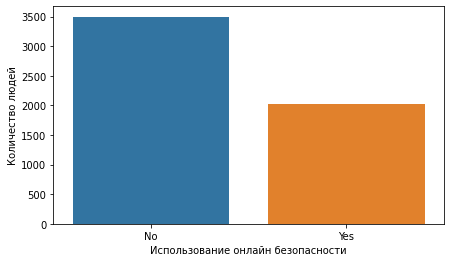

No     3497
Yes    2015
Name: OnlineSecurity, dtype: int64
Количество пропусков:  1520


In [29]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=data, x='OnlineSecurity')
plt.ylabel('Количество людей')
plt.xlabel('Использование онлайн безопасности')
plt.show()
print(data['OnlineSecurity'].value_counts())
print('Количество пропусков: ', data['OnlineSecurity'].isna().sum())

Больше клиентов, которые не пользуются онлайн безопасностью

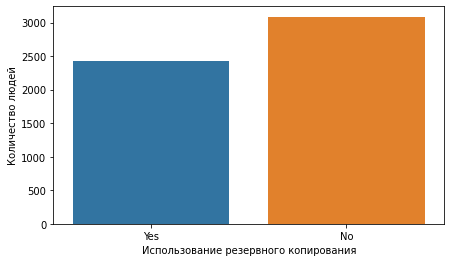

No     3087
Yes    2425
Name: OnlineBackup, dtype: int64
Количество пропусков:  1520


In [30]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=data, x='OnlineBackup')
plt.ylabel('Количество людей')
plt.xlabel('Использование резервного копирования')
plt.show()
print(data['OnlineBackup'].value_counts())
print('Количество пропусков: ', data['OnlineBackup'].isna().sum())

Клиентов не использующих резервное копирование также больше, чем использующих

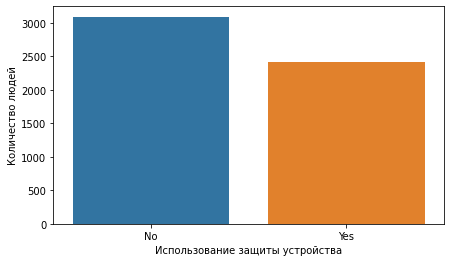

No     3094
Yes    2418
Name: DeviceProtection, dtype: int64
Количество пропусков:  1520


In [31]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=data, x='DeviceProtection')
plt.ylabel('Количество людей')
plt.xlabel('Использование защиты устройства')
plt.show()
print(data['DeviceProtection'].value_counts())
print('Количество пропусков: ', data['DeviceProtection'].isna().sum())

Клиентов не использующих защиту устройства также чуть больше, чем использующих

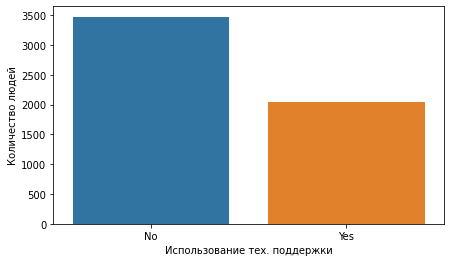

No     3472
Yes    2040
Name: TechSupport, dtype: int64
Количество пропусков:  1520


In [32]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=data, x='TechSupport')
plt.ylabel('Количество людей')
plt.xlabel('Использование тех. поддержки')
plt.show()
print(data['TechSupport'].value_counts())
print('Количество пропусков: ', data['TechSupport'].isna().sum())

Клиентов не использующих услуги тех. поддержки также больше, чем использующих

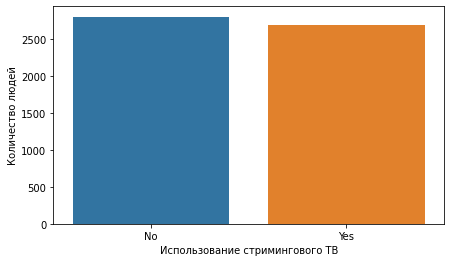

No     2809
Yes    2703
Name: StreamingTV, dtype: int64
Количество пропусков:  1520


In [33]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=data, x='StreamingTV')
plt.ylabel('Количество людей')
plt.xlabel('Использование стримингового ТВ')
plt.show()
print(data['StreamingTV'].value_counts())
print('Количество пропусков: ', data['StreamingTV'].isna().sum())

Клиентов использующих и не использующих услуги стримингового ТВ почти равное количество

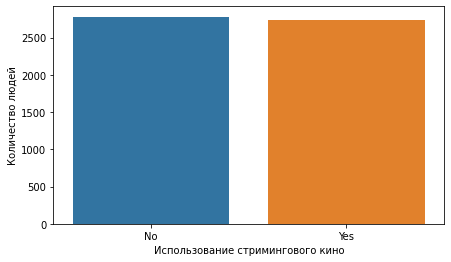

No     2781
Yes    2731
Name: StreamingMovies, dtype: int64
Количество пропусков:  1520


In [34]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=data, x='StreamingMovies')
plt.ylabel('Количество людей')
plt.xlabel('Использование стримингового кино')
plt.show()
print(data['StreamingMovies'].value_counts())
print('Количество пропусков: ', data['StreamingMovies'].isna().sum())

Клиентов использующих и не использующих услуги стримингового кино также почти равное количество

Из всего вышесказанного мы можем сделать вывод, что из дополнительных интернет-услуг востребованы только стриминговое ТВ и стриминговое кино - их использует около половины пользователей интернета, остальные услуги использует еще меньший процент пользователей

Заполним пропуски с столбцах с интернет-услугами значением 'No'

In [35]:
data['OnlineSecurity'] = data['OnlineSecurity'].fillna('No')
data['OnlineBackup'] = data['OnlineBackup'].fillna('No')
data['DeviceProtection'] = data['DeviceProtection'].fillna('No')
data['TechSupport'] = data['TechSupport'].fillna('No')
data['StreamingTV'] = data['StreamingTV'].fillna('No')
data['StreamingMovies'] = data['StreamingMovies'].fillna('No')

Осталось посмотреть на информация об услугах телефонии. Посмотрим на столбец 'MultipleLines' - в нем содержится информация о возможности ведения параллельной линии во время звонка. Также нам необходимо посмотреть на пропуски в этом столбце

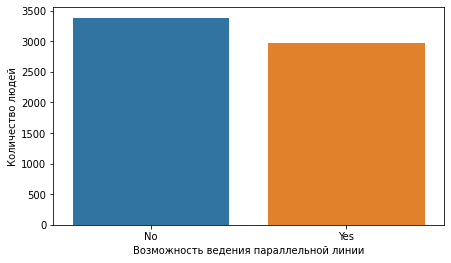

No     3385
Yes    2967
Name: MultipleLines, dtype: int64
Количество пропусков:  680


In [36]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=data, x='MultipleLines' )
plt.ylabel('Количество людей')
plt.xlabel('Возможность ведения параллельной линии')
plt.show()
print(data['MultipleLines'].value_counts())
print('Количество пропусков: ', data['MultipleLines'].isna().sum())

Как мы видим чуть чаще у клиентов нет возможности ведения параллельной линии. Поскольку мы не знаем наверняка о такой возможности у клиентов, которые не пользуются услугами телефонии, поэтому заполним пропуски значением 'unknown'

In [37]:
data['MultipleLines'] = data['MultipleLines'].fillna('unknown')

Обратим внимание на столбцы с непосредственными датами заключения и расторжения договоров, а также уникальный идентификатор клиента: поскольку они являются индивидуальными и не смогут помочь нам в предсказаниях удалим эти столбцы

In [38]:
data = data.drop(['BeginDate','EndDate', 'customerID'], axis = 1)

Посмотрим как теперь выглядит датасет:

In [39]:
display(data.sample(10))
data.info()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,status,time
6108,Month-to-month,No,Mailed check,25.15,452.70,Male,0,No,No,DSL,No,No,No,No,No,No,unknown,1.0,549
6614,Two year,No,Credit card (automatic),19.70,1398.70,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,1.0,2163
2599,Two year,Yes,Credit card (automatic),73.00,5676.48,Female,0,No,No,DSL,Yes,Yes,Yes,Yes,No,Yes,No,1.0,2191
4350,Month-to-month,Yes,Credit card (automatic),44.55,1470.15,Male,0,Yes,No,DSL,No,No,No,No,No,No,No,1.0,1006
6732,Month-to-month,Yes,Electronic check,89.55,2149.20,Female,0,No,No,Fiber optic,No,No,No,Yes,No,Yes,Yes,1.0,730
2648,Month-to-month,Yes,Electronic check,59.60,2086.00,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,Yes,1.0,1067
1745,Two year,Yes,Credit card (automatic),19.80,1108.80,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,1.0,1706
3383,Month-to-month,Yes,Electronic check,75.50,727.07,Male,0,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,1.0,276
3721,Month-to-month,No,Mailed check,20.65,61.95,Female,0,No,No,No,No,No,No,No,No,No,No,1.0,92
1283,Two year,Yes,Electronic check,105.50,7596.00,Female,0,Yes,No,Fiber optic,Yes,No,Yes,No,Yes,Yes,Yes,1.0,2191


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   gender            7032 non-null   object 
 6   SeniorCitizen     7032 non-null   int64  
 7   Partner           7032 non-null   object 
 8   Dependents        7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  MultipleLines     7032 non-null   object 


Как мы видим с пропусками мы разобрались, создали новые признаки и удалили лишние, поменяли тип данных там, где это было необходимо.

Посмотрим на созданные нами признаки и оценим баланс классов в целевом признаке

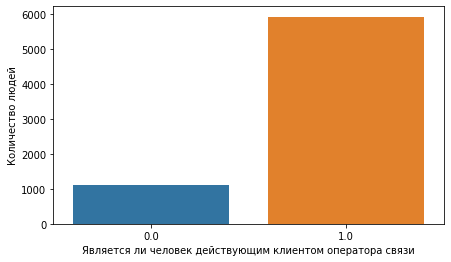

1.0    5931
0.0    1101
Name: status, dtype: int64


In [40]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=data, x='status')
plt.ylabel('Количество людей')
plt.xlabel('Является ли человек действующим клиентом оператора связи')
plt.show()
print(data['status'].value_counts())

Как мы видим у нас имеется дисбаланс классов (действующих пользователей почти в 6 раз больше чем ушедших). Но поскольку мы планируем использовать метрику ROC-AUC, которая не чувствительна к дисбалансу, то оставим это без изменений

Посмотрим на время пользования услугами и построим соответствующий график

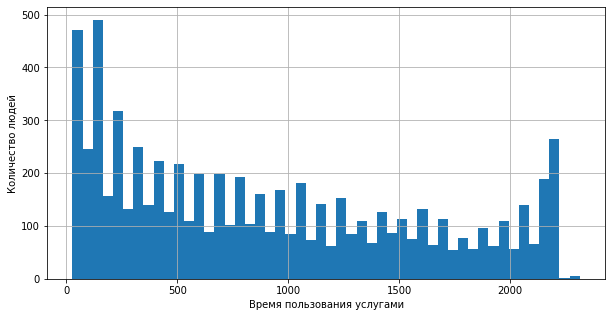

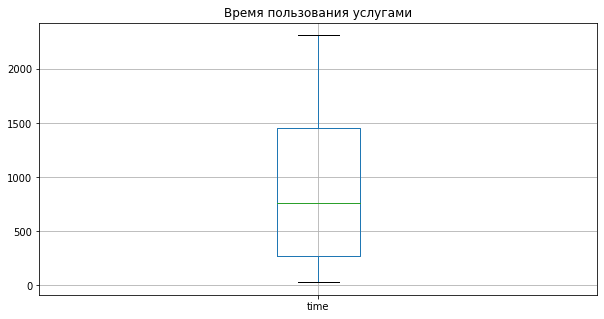

count    7032.000000
mean      899.961320
std       682.738777
min        28.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: time, dtype: float64

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
data['time'].hist(bins = 50)
plt.ylabel('Количество людей')
plt.xlabel('Время пользования услугами')
plt.show()
fig, ax = plt.subplots(figsize=(10, 5))
data.boxplot(column='time')
plt.title('Время пользования услугами')
plt.show()
data['time'].describe()

Как мы видим, клиенты чаще всего пользуются услугами от 276 до 1461 дней - то есть от 0,75 года до 4 лет, минимальное значение пользования - один месяц, а максимальное - 6 с лишним лет, что выглядит правдоподобно

Изучим мультиколлинеарность в нашем датасете. Для этого посмотрим на 𝜙k (Phik) коэффициент корреляции и построим матрицу, содержащую попарные коэффициенты 𝜙k между нашими признаками

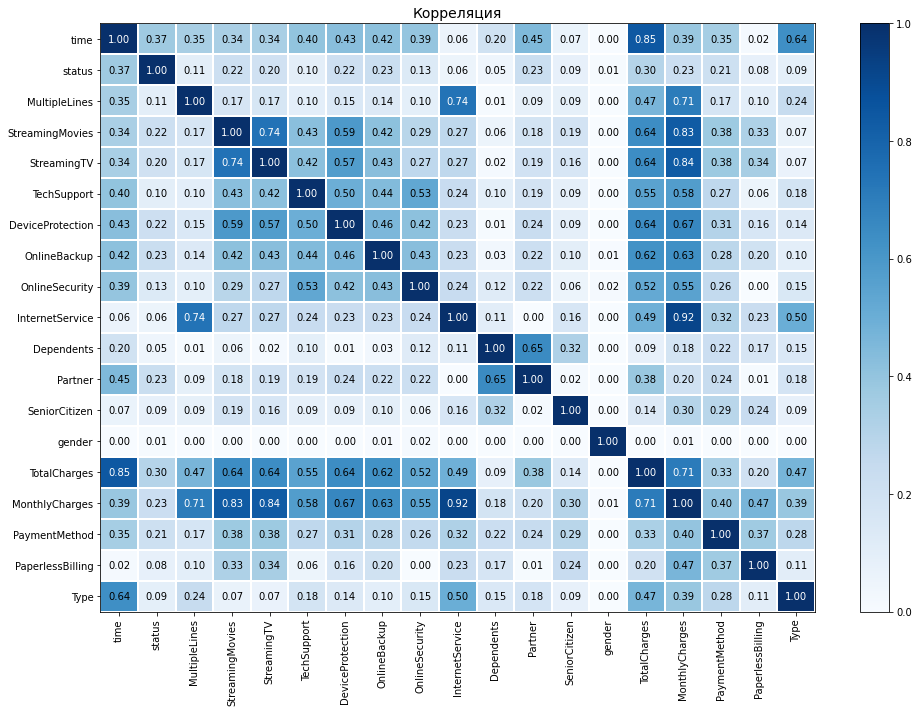

In [42]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'time']
phik_overview = data.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title="Корреляция", 
                        fontsize_factor=1, 
                        figsize=(14, 10))
plt.tight_layout()

Как мы видим присутствует средняя и высокая корреляция между ежемесячными тратами на услуги и дополнительными интернет-услугами и средняя корреляция между суммарными тратами на услуги и дополнительными интернет-услугами, а также высокая корреляция между суммарными тратами на услуги и временем пользования услугами, что вполне логично

<b>Вывод: </b> Мы проанализировали каждый признак нашего датасета, построили графики, обработали пропуски и избавились от лишних признаков, проанализировали баланс классов и оценили корреляцию между признаками

## Обучение моделей

Перед обучением модели нам необходимо разделить датасет на выборки

Разобьем данные на выборки: выделим 25% данных для тестовой выборки, остальные 75% — для обучающей

In [43]:
data_train, data_test = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE)

Целевым признаком в нашем датасете является столбец "status" - именно в нем содержится информацию о статусе клиенте (является ли он клиентом оператора или уже нет) и его нам необходимо будет предсказывать. Остальные столбцы датасета будут признаками. Создадим переменные для признаков и целевого признака для каждой выборки

In [44]:
features_train = data_train.drop(['status'], axis=1)
target_train = data_train['status']
features_test = data_test.drop(['status'], axis=1)
target_test = data_test['status']

Для преобразования категориальных признаков в численные воспользуемся техникой OHE. Перед этим в переменной category создадим список всех категориальных признаков

In [45]:
category = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [46]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder.fit(features_train[category])

features_train[encoder.get_feature_names_out()] = encoder.transform(features_train[category])
features_train = features_train.drop(category, axis=1)

features_test[encoder.get_feature_names_out()] = encoder.transform(features_test[category])
features_test = features_test.drop(category, axis=1)

Стандартизируем численные признаки. Перед этим в переменной numeric создадим список всех численных признаков

In [47]:
numeric = ['MonthlyCharges', 'TotalCharges', 'time']

scaler = StandardScaler() 
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Далее применим три модели и посмотрим какая из них покажет наилучшие результаты

Применим модель 'Логистической регрессии' подбирая параметры через GridSearch и посмотрим на лучший результат, который продемонстрирует модель

In [48]:
%%time

model = LogisticRegression(random_state=RANDOM_STATE)
param_grid = {'max_iter': range(100, 500, 100), 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'solver'  : ['newton-cg', 'lbfgs', 'liblinear']}

gs_l = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
gs_l.fit(features_train, target_train)

print("Лучший результат 'Логистической регрессии':", gs_l.best_score_)
print("Лучшие параметры 'Логистической регрессии':", gs_l.best_params_)
print('Время обучения и предсказания модели:') 

Лучший результат 'Логистической регрессии': 0.7721530486608409
Лучшие параметры 'Логистической регрессии': {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}
Время обучения и предсказания модели:
CPU times: user 1min 24s, sys: 1min 44s, total: 3min 9s
Wall time: 3min 10s


Далее применим модель 'Случайный лес' подбирая параметры через RandomizedSearch

In [49]:
%%time

model = RandomForestClassifier(random_state=RANDOM_STATE)
param_rand = {'n_estimators': range(10, 500, 10), 'max_depth': range(1,15), 
              'min_samples_leaf': range (1,10), 'min_samples_split': range (2,10)}

gs_r = RandomizedSearchCV(model, param_rand, cv=5, scoring='roc_auc', n_jobs=-1)
gs_r.fit(features_train, target_train)

print("Лучший результат 'Случайного леса':", gs_r.best_score_)
print("Лучшие параметры 'Случайного леса':", gs_r.best_params_)
print('Время обучения и предсказания модели:') 

Лучший результат 'Случайного леса': 0.8234744524424557
Лучшие параметры 'Случайного леса': {'n_estimators': 440, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 7}
Время обучения и предсказания модели:
CPU times: user 48.2 s, sys: 0 ns, total: 48.2 s
Wall time: 48.3 s


И применим модель 'CatBoost' подбирая параметры через RandomizedSearch

In [50]:
%%time

model = CatBoostClassifier(random_state=RANDOM_STATE)
param_grid = {'iterations': range(100, 1000, 100),'depth': range(1, 10),
              'learning_rate' : [0.01, 0.03, 0.05, 0.1]}

gs_c = RandomizedSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
gs_c.fit(features_train, target_train, verbose=0)

print("Лучший результат 'CatBoost':", gs_c.best_score_)
print("Лучшие параметры 'CatBoost':", gs_c.best_params_)
print('Время обучения и предсказания модели:') 

Лучший результат 'CatBoost': 0.9017223000195178
Лучшие параметры 'CatBoost': {'learning_rate': 0.1, 'iterations': 400, 'depth': 6}
Время обучения и предсказания модели:
CPU times: user 2min 19s, sys: 0 ns, total: 2min 19s
Wall time: 3min 16s


Как мы видим наилучшие результаты продемонстрировала модель 'CatBoost' с параметрами: 'learning_rate': 0.1, 'iterations': 400, 'depth': 6

<b>Вывод: </b> нами было произведено кодирование и стандартизация признаков, проведено испытание трех моделей машинного обучения с подбором параметров. Наилучший результат продемонстрировала модель 'CatBoost'

## Тестирование модели

Проверим нашу наилучшую модель на тестовой выборке. Основной метрикой для нас будет ROC-AUC, дополнительной - Accuracy

In [51]:
probabilities_valid = gs_c.best_estimator_.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
answer = gs_c.best_estimator_.predict(features_test)
accuracy = accuracy_score(target_test, answer)
roc_auc = roc_auc_score(target_test, probabilities_one_valid)
print("ROC-AUC на тестовой выборке:", roc_auc)
print("Accuracy на тестовой выборке:", accuracy)

ROC-AUC на тестовой выборке: 0.9103083930704899
Accuracy на тестовой выборке: 0.9163822525597269


Как мы видим нам удалось достичь требуемого значения метрики ROC-AUC ( > 0.85), значит наша модель подходит заказчику

Также мы можем построить ROC-кривую для наглядности

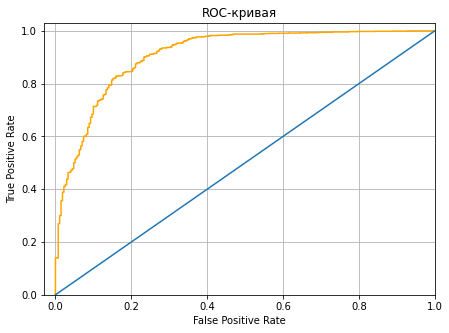

In [52]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="orange") 
plt.plot([0, 1], [0, 1], linestyle='-')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.03])
plt.title("ROC-кривая") 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

А также построим матрицу ошибок

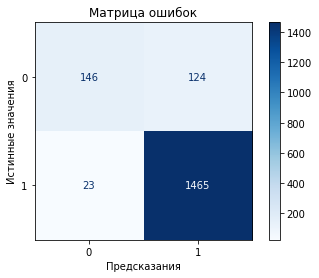

In [53]:
cm = confusion_matrix(target_test, answer)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.title('Матрица ошибок')
plt.xlabel('Предсказания')
plt.ylabel('Истинные значения')
plt.show()

Как мы видим сумма истинно позитивных и истинно отрицательных предсказаний существенно превышает сумму ошибочно положительных и ошибочно отрицательных предсказаний (что и подтверждает метрика Accuracy). Доля ошибочно положительных предсказаний больше доли ошибочно отрицательных

В заключение проведем анализ важности признаков, построим соответствующий график и посмотрим какие признаки оказались наиболее важными для нас

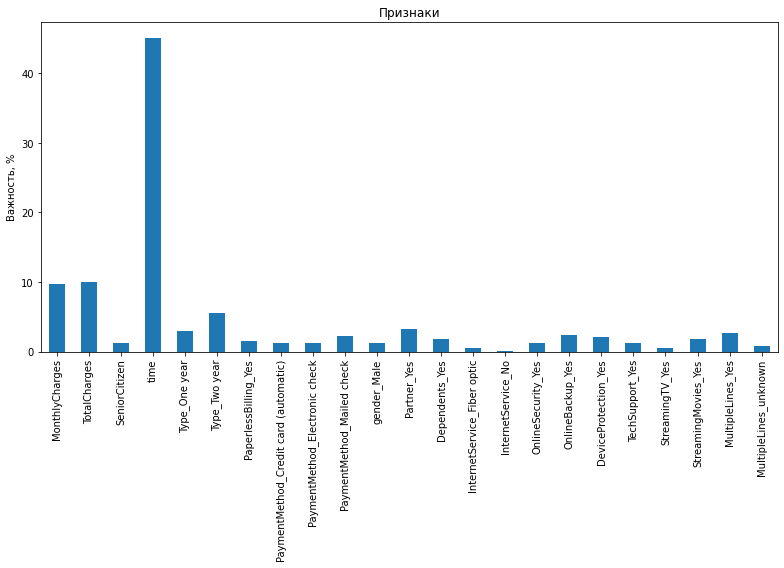

In [54]:
feature_importances = pd.Series(gs_c.best_estimator_.get_feature_importance(), features_train.columns)
fig, ax = plt.subplots(figsize=(11,8))
feature_importances.plot.bar(ax=ax)
ax.set_title("Признаки")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Как мы видим наибольшее влияние с большим отрывом оказывает время пользования услугами, далее следуют ежемесячные траты на услуги и суммарные траты на услуги, остальные признаки имеют еще меньшую важность (около 5% и менее)

<b>Вывод: </b> нами был обработан исходный датасет, заполнены пропуски, проанализированы и добавлены новые признаки, подготовлено и протестировано несколько моделей. Проанализировав критерии заказчика мы пришли к выводу, что наиболее подходящей моделью будет "CatBoost" - проверка на тестовой выборке это подтвердила и требуемое значение метрики ROC-AUC было достигнуто. Таким образом наша модель сможет помочь спрогнозировать отток клиентов оператору связи.

## Отчет по решению

### Ключевые пункты плана

Проанализируем проделанную работу и посмотрим все ли пункта первоначального плана нам удалось выполнить. Для этого еще раз взглянем на план и отметим выполненные пункты

1. [x] Подготовка данных: импорт необходимых для работы библиотек, загрузка датасетов, вывод информации о них, перевод данных в необходимые форматы (при необходимости), оценка количества дубликатов и пропусков, работа с ними
2. [x]  Анализ данных: оценка признаков и целевого признака, построение графиков, изучение мультиколлинеарности и баланса классов
3. [x]  Обучение моделей: разделение датасета на выборки, преобразования категориальных признаков в численные, стандартизация численных признаков, построение нескольких моделей и оценка метрик на каждой из моделей, а также оценка времени обучения и предсказания 
4. [x]  Тестирование модели: выбор наилучшей модели из обученных ранее, проверка выбранной модели на тестовой выборке, оценка метрик полученных  на тестовой выборке
5. [x]  Выводы о проделанной работе

Как видим все пункты плана выполнены, в некоторых местах дополнительно построены графики и написаны промежуточные выводы

### Основные трудности при выполнении

Особых трудностей проект не вызвал, но некоторые из них были связаны с подбором гиперпараметров - на их подбор с помощью GridSearchCV уходило много времени, поэтому было принято решение использовать подбор параметров через RandomizedSearchCV для двух наиболее долго выполняемых моделей

### Ключевые шаги в решении

Ключевые шаги в решении задачи во много коррелируют с планом решения задачи. Выделим ключевые шаги:

- Предобработка данных, выявление пропусков, дубликатов и аномалий
- Анализ данных: оценка признаков, создание целевого признака
- Подготовка данных к обучению: разделение на выборки, кодирование и масштабирование признаков
- Обучение моделей и выбор наилучшей из них
- Тестирование наилучшей модели

### Признаки для обучения модели

   Для обучения модели были использованы практически все признаки из первоначальных датасетов за исключением 'BeginDate' (дата начала пользования услугами), 'EndDate' (дата окончания пользования услугами) и 'customerID' (уникальный идентификатор клиента) поскольку они являются индивидуальными для каждого клиента и не смогли бы помочь нам в предсказаниях.
   
   Также на основе удаленных признаков с информацией о дате начала и дате окончания пользования услугами были созданы признаки 'time' (время пользования услугами) и 'status' (информация о статусе клиента). Признак 'status' выбран в качестве целевого. 
   
   Полный список признаков, участвующих в обучении модели: 'Type',	'PaperlessBilling',	'PaymentMethod',	'MonthlyCharges',	'TotalCharges',	'gender', 'SeniorCitizen',	'Partner',	'Dependents',	'InternetService',	'OnlineSecurity',	'OnlineBackup',	'DeviceProtection',	'TechSupport',	'StreamingTV',	'StreamingMovies',	'MultipleLines',	'time'.\
   Целевой признак: 'status'
   
   
   Признаки, используемые для обучения модели были проверены на аномальные значения, также были заполнены пропуски и удалена небольшая часть данных, которая могла испортить картину будущих предсказаний (клиенты, начавшие пользование услугами в день выгрузки данных)
   
   В конце работы была проведена оценка важности признаков и построен соответствующий график

### Итоговая модель, её гиперпараметы и качество

Итоговой моделью была выбрана модель "CatBoost" со следующими гиперпараметрами, подобранными с помощью RandomizedSearchCV:
- 'learning_rate': 0.1
- 'iterations': 400
- 'depth': 6
-  random_state=240423

Данная модель обеспечила следующие значения метрик на тестовой выборке:
- ROC-AUC (основная метрика) :  0.910 
- Accuracy (дополнительная метрика) :  0.916 

<b>Примечание: </b> Поскольку подбор гиперпараметров осуществлялся с помощью RandomizedSearchCV с целью экономии времени, повторный запуск может выдать другие значения гиперпараметров и соответственно другие значения метрики ROC-AUC. Однако для данной модели в ходе нескольких испытаний (более 5) значение метрики ROC-AUC было в пределах 0.88-0.92, что в любом случае обеспечивает требуемое значения метрики ROC-AUC ( > 0.85)

### Вывод

Нами были произведены предобработка и анализ данных, подготовка данных к обучению и обучение нескольких моделей. Проанализировав полученные результаты обучения мы пришли к выводу, что наиболее подходящей моделью будет "CatBoost" - проверка на тестовой выборке это подтвердила и требуемое значение метрики ROC-AUC было достигнуто. Таким образом наша модель сможет помочь спрогнозировать отток клиентов оператору связи.